In [1]:
import requests
import time
import concurrent.futures
import json
import matplotlib.pyplot as plt

# --- Configuration ---
# The Load Balancer URL provided
BASE_URL = "http://afe488ae7989147b1aeb024687155e28-1864897881.us-east-2.elb.amazonaws.com/llmd-demo/qwen3-8b-cachi-llmd"
API_URL = f"{BASE_URL}/v1/chat/completions"
MODEL_ID = "RedHatAI/Qwen3-8B-FP8-dynamic"

print(f"Targeting API: {API_URL}")
print(f"Model: {MODEL_ID}")

Targeting API: http://afe488ae7989147b1aeb024687155e28-1864897881.us-east-2.elb.amazonaws.com/llmd-demo/qwen3-8b-cachi-llmd/v1/chat/completions
Model: RedHatAI/Qwen3-8B-FP8-dynamic


In [2]:
# Create a Realistic Heavy System Prompt (~1200+ tokens)
# We simulate a "Legal Document Assistant" scenario.
CONTRACT_TEXT = """
AGREEMENT FOR CONSULTING SERVICES
1. CONFIDENTIALITY. The Consultant acknowledges that they may have access to confidential information of the Company ("Confidential Information"). The Consultant agrees not to disclose such Confidential Information to any third party.
2. INDEPENDENT CONTRACTOR. The Consultant is an independent contractor and not an employee of the Company. 
3. LIMITATION OF LIABILITY. IN NO EVENT SHALL EITHER PARTY BE LIABLE FOR INDIRECT DAMAGES.
""" 

# Repeat text 40 times to ensure the 'prefill' phase is computationally expensive
SYSTEM_CONTEXT = "You are a legal assistant analyzing this contract: " + (CONTRACT_TEXT * 40)

print(f"System Context Length: {len(SYSTEM_CONTEXT)} characters")
print("Context is ready for caching.")

System Context Length: 18811 characters
Context is ready for caching.


In [3]:
def simulate_user_session(user_id, question, delay_seconds=0):
    """
    Simulates a single user interaction with an optional start delay.
    """
    # Artificial delay to ensure specific ordering (Cold Start vs Cache Hit)
    if delay_seconds > 0:
        time.sleep(delay_seconds)

    payload = {
        "model": MODEL_ID,
        "messages": [
            {"role": "system", "content": SYSTEM_CONTEXT},
            {"role": "user", "content": question}
        ],
        "temperature": 0.1,
        "max_tokens": 50 
    }

    print(f"🚀 [{user_id}] Sending request...")
    
    start_time = time.time()
    try:
        response = requests.post(
            API_URL, 
            json=payload, 
            headers={"Content-Type": "application/json"}
        )
        response.raise_for_status()
        
        # Calculate Latency
        end_time = time.time()
        latency = end_time - start_time
        
        # Parse content
        content = response.json()['choices'][0]['message']['content']
        # Clean up newlines for display
        short_content = content.replace("\n", " ")[:60]
        
        return {
            "user": user_id,
            "latency": latency,
            "response_snippet": short_content,
            "status": "Success"
        }
    except Exception as e:
        return {
            "user": user_id, 
            "latency": 0, 
            "response_snippet": "N/A", 
            "status": f"Error: {str(e)}"
        }

In [4]:
# Define our test scenarios
# User A: Goes first (Cold Start)
# User B & C: Go 2.5s and 3.0s later (Should hit the cache created by A)
scenarios = [
    {"id": "User_A", "delay": 0,   "q": "Summarize section 1 regarding confidentiality."},
    {"id": "User_B", "delay": 2.5, "q": "Is the consultant an employee? Check section 2."},
    {"id": "User_C", "delay": 3.0, "q": "What does section 3 say about liability?"}
]

results = []

print("--- Starting Concurrent Test ---")

# Run requests in parallel threads
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    # Submit all tasks
    futures = [
        executor.submit(simulate_user_session, s["id"], s["q"], s["delay"]) 
        for s in scenarios
    ]
    
    # Wait for completion
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

# Sort results alphabetically by User ID for consistent reading
results.sort(key=lambda x: x['user'])
print("--- Test Complete ---")

--- Starting Concurrent Test ---
🚀 [User_A] Sending request...
🚀 [User_B] Sending request...
🚀 [User_C] Sending request...
--- Test Complete ---



User       | Latency (s)  | Type            | Snippet
----------------------------------------------------------------------
User_A     | 2.9675       | COLD BASE ❄️    | <think> Okay, the user wants a summary of section 1 regardin...
User_B     | 2.5432       | COLD MISS ❄️    | <think> Okay, the user is asking if the consultant is an emp...
User_C     | 2.0423       | WARM HIT 🔥      | <think> Okay, the user is asking about Section 3 of the cont...


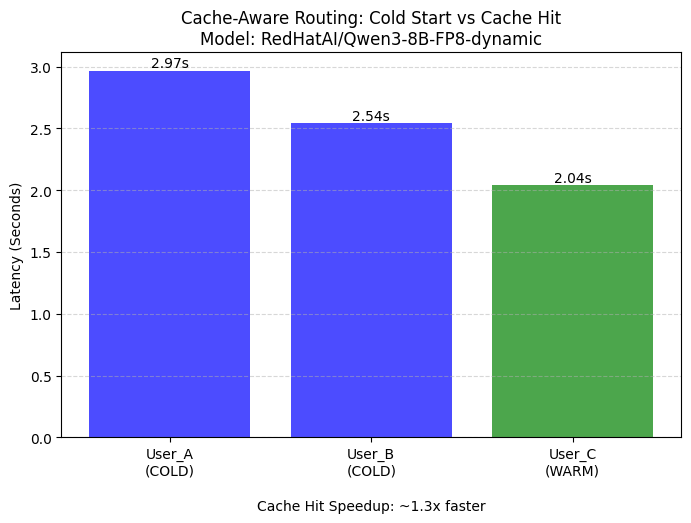

In [5]:
# --- Table Output ---
print(f"\n{'User':<10} | {'Latency (s)':<12} | {'Type':<15} | {'Snippet'}")
print("-" * 70)

latencies = []
labels = []
colors = []

# Baseline is User A (first request)
base_latency = results[0]['latency']

for res in results:
    lat = res['latency']
    user = res['user']
    
    # Heuristic: If latency is < 70% of User A, it's a Cache Hit
    is_hit = lat < (base_latency * 0.7)
    type_str = "WARM HIT 🔥" if is_hit and user != "User_A" else "COLD MISS ❄️"
    if user == "User_A": type_str = "COLD BASE ❄️"
    
    print(f"{user:<10} | {lat:<12.4f} | {type_str:<15} | {res['response_snippet']}...")
    
    # Prepare data for plotting
    latencies.append(lat)
    labels.append(f"{user}\n({type_str.split()[0]})")
    colors.append('green' if "HIT" in type_str else 'blue')

# --- Graph Output ---
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, latencies, color=colors, alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom')

plt.ylabel('Latency (Seconds)')
plt.title(f'Cache-Aware Routing: Cold Start vs Cache Hit\nModel: {MODEL_ID}')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Calculate speedup
if len(latencies) > 1:
    avg_hit = sum(latencies[1:]) / len(latencies[1:])
    speedup = base_latency / avg_hit
    plt.xlabel(f"\nCache Hit Speedup: ~{speedup:.1f}x faster")

plt.show()